# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    # TODO
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concatened_layers = layers.concatenate([upsampled_layer, large_ip_layer])
    # TODO Add some number of separable convolution layers
    separable_layer = separable_conv2d_batchnorm(concatened_layers, filters, 1)
    output_layer = separable_conv2d_batchnorm(separable_layer, filters, 1)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    print("Features Layer", inputs.shape)
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    encoder_1_layer = encoder_block(inputs, 32, 2)
    encoder_2_layer = encoder_block(encoder_1_layer, 64, 2)
    encoder_3_layer = encoder_block(encoder_2_layer, 128, 2)
    print("Encoder 1", encoder_1_layer.shape)
    print("Encoder 2", encoder_2_layer.shape)
    print("Encoder 3", encoder_3_layer.shape)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    conv_1_1_layer = conv2d_batchnorm(encoder_3_layer, 128, 1, 1)
    print("1x1 Conv", conv_1_1_layer.shape)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decoder_1_layer = decoder_block(conv_1_1_layer, encoder_2_layer, 128)
    print("Decoder 1", decoder_1_layer.shape)
    decoder_2_layer = decoder_block(decoder_1_layer, encoder_1_layer, 64)
    print("Decoder 2", decoder_2_layer.shape)
    decoder_3_layer = decoder_block(decoder_2_layer, inputs, 32)
    print("Decoder 3", decoder_2_layer.shape)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    output_layer = layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(decoder_3_layer)
    print("Output Layer", output_layer.shape)
    
    return output_layer


## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

Features Layer (?, 160, 160, 3)
Encoder 1 (?, 80, 80, 32)
Encoder 2 (?, 40, 40, 64)
Encoder 3 (?, 20, 20, 128)
1x1 Conv (?, 20, 20, 128)
Decoder 1 (?, 40, 40, 128)
Decoder 2 (?, 80, 80, 64)
Decoder 3 (?, 80, 80, 64)
Output Layer (?, 160, 160, 3)


### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [ ]:
learning_rate = 0.0001
batch_size = 32
num_epochs = 115
steps_per_epoch = int(4131/batch_size)-1#200
validation_steps = int(1000/batch_size)
workers = 1 # Using GPU.

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [ ]:
# Save your trained model weights
weight_file_name = 'model_weights-1'
model_tools.save_network(model, weight_file_name)

Features Layer (?, 160, 160, 3)
Encoder 1 (?, 80, 80, 32)
Encoder 2 (?, 40, 40, 64)
Encoder 3 (?, 20, 20, 128)
1x1 Conv (?, 20, 20, 128)
Decoder 1 (?, 40, 40, 128)
Decoder 2 (?, 80, 80, 64)
Decoder 3 (?, 80, 80, 64)
Output Layer (?, 160, 160, 3)
Epoch 1/115
127/128 [============================>.] - ETA: 0s - loss: 0.1502

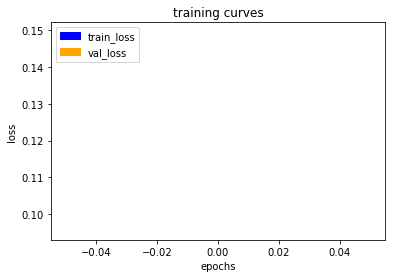

128/128 [==============================] - 78s - loss: 0.1494 - val_loss: 0.0957
Epoch 2/115
127/128 [============================>.] - ETA: 0s - loss: 0.0442

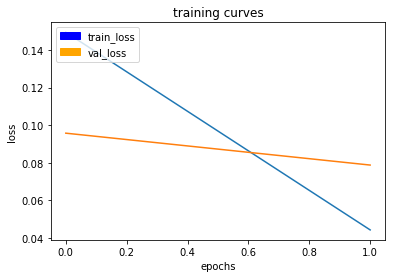

128/128 [==============================] - 73s - loss: 0.0443 - val_loss: 0.0788
Epoch 3/115
127/128 [============================>.] - ETA: 0s - loss: 0.0391

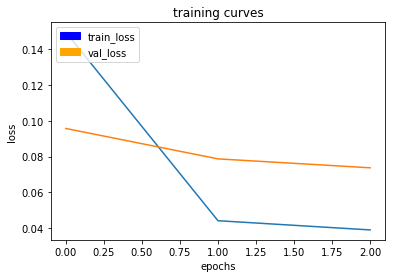

128/128 [==============================] - 73s - loss: 0.0391 - val_loss: 0.0738
Epoch 4/115
127/128 [============================>.] - ETA: 0s - loss: 0.0354

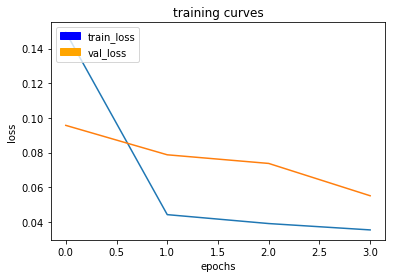

128/128 [==============================] - 73s - loss: 0.0353 - val_loss: 0.0551
Epoch 5/115
127/128 [============================>.] - ETA: 0s - loss: 0.0317

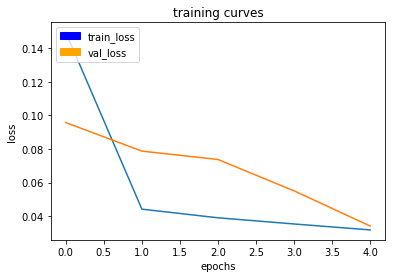

128/128 [==============================] - 73s - loss: 0.0318 - val_loss: 0.0342
Epoch 6/115
127/128 [============================>.] - ETA: 0s - loss: 0.0307

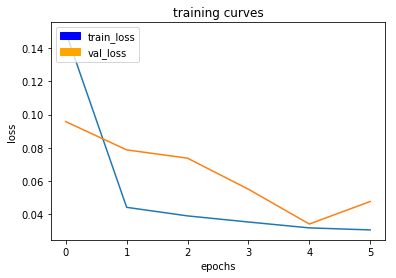

128/128 [==============================] - 73s - loss: 0.0307 - val_loss: 0.0477
Epoch 7/115
127/128 [============================>.] - ETA: 0s - loss: 0.0280

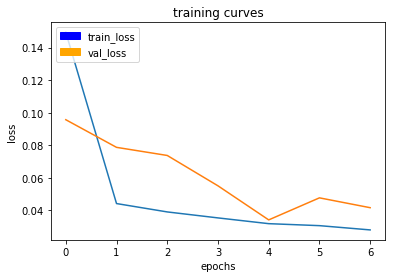

128/128 [==============================] - 73s - loss: 0.0280 - val_loss: 0.0417
Epoch 8/115
127/128 [============================>.] - ETA: 0s - loss: 0.0274

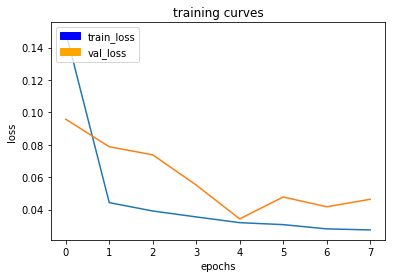

128/128 [==============================] - 73s - loss: 0.0274 - val_loss: 0.0463
Epoch 9/115
127/128 [============================>.] - ETA: 0s - loss: 0.0260

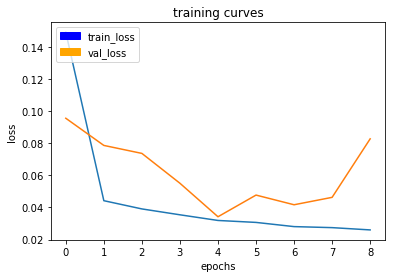

128/128 [==============================] - 74s - loss: 0.0260 - val_loss: 0.0829
Epoch 10/115
127/128 [============================>.] - ETA: 0s - loss: 0.0264

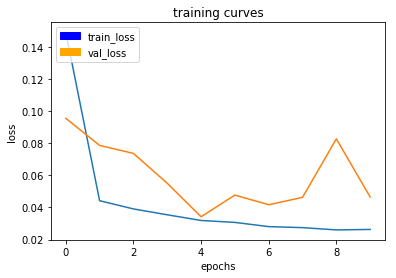

128/128 [==============================] - 73s - loss: 0.0264 - val_loss: 0.0465
Epoch 11/115
127/128 [============================>.] - ETA: 0s - loss: 0.0237

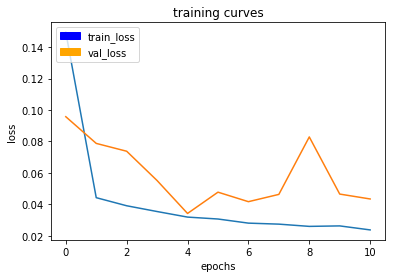

128/128 [==============================] - 73s - loss: 0.0237 - val_loss: 0.0434
Epoch 12/115
127/128 [============================>.] - ETA: 0s - loss: 0.0240

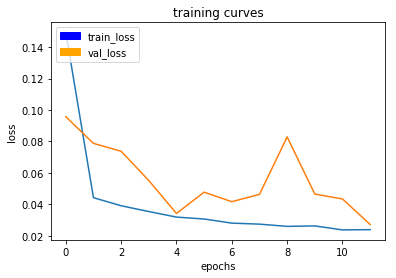

128/128 [==============================] - 74s - loss: 0.0240 - val_loss: 0.0272
Epoch 13/115
127/128 [============================>.] - ETA: 0s - loss: 0.0230

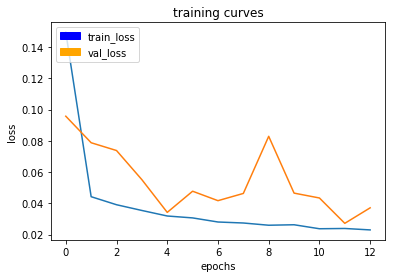

128/128 [==============================] - 73s - loss: 0.0231 - val_loss: 0.0371
Epoch 14/115
127/128 [============================>.] - ETA: 0s - loss: 0.0241

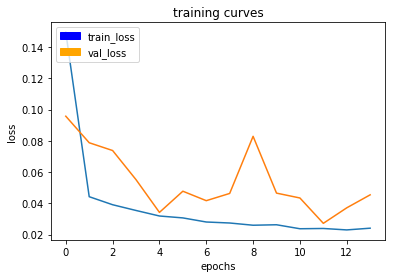

128/128 [==============================] - 74s - loss: 0.0241 - val_loss: 0.0454
Epoch 15/115
127/128 [============================>.] - ETA: 0s - loss: 0.0223

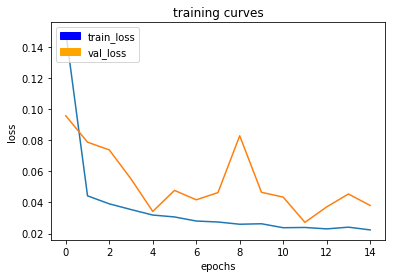

128/128 [==============================] - 73s - loss: 0.0223 - val_loss: 0.0380
Epoch 16/115
127/128 [============================>.] - ETA: 0s - loss: 0.0221

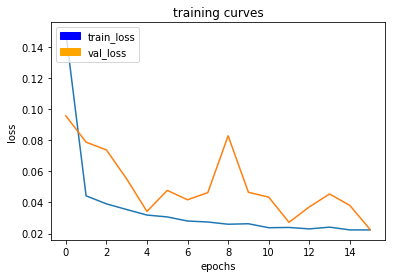

128/128 [==============================] - 73s - loss: 0.0223 - val_loss: 0.0226
Epoch 17/115
127/128 [============================>.] - ETA: 0s - loss: 0.0204

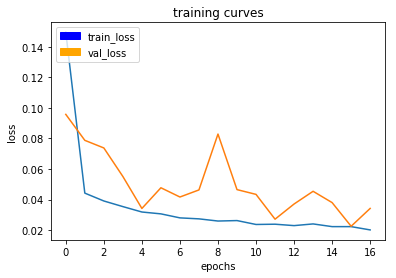

128/128 [==============================] - 74s - loss: 0.0204 - val_loss: 0.0342
Epoch 18/115
127/128 [============================>.] - ETA: 0s - loss: 0.0202

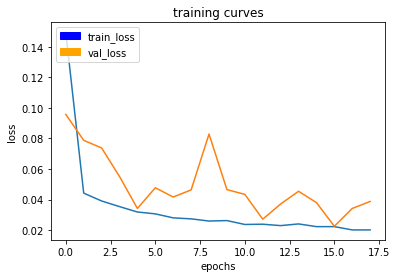

128/128 [==============================] - 73s - loss: 0.0202 - val_loss: 0.0388
Epoch 19/115
127/128 [============================>.] - ETA: 0s - loss: 0.0205

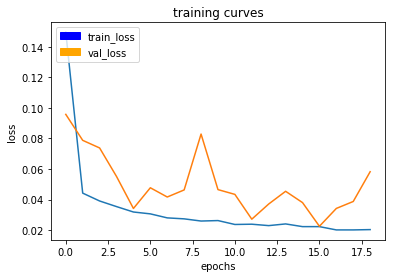

128/128 [==============================] - 73s - loss: 0.0205 - val_loss: 0.0582
Epoch 20/115
127/128 [============================>.] - ETA: 0s - loss: 0.0197

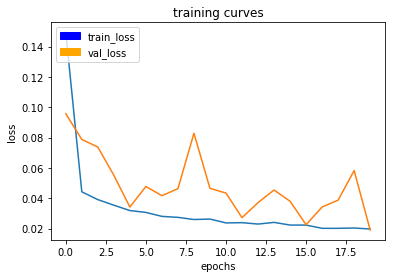

128/128 [==============================] - 73s - loss: 0.0197 - val_loss: 0.0191
Epoch 21/115
127/128 [============================>.] - ETA: 0s - loss: 0.0186

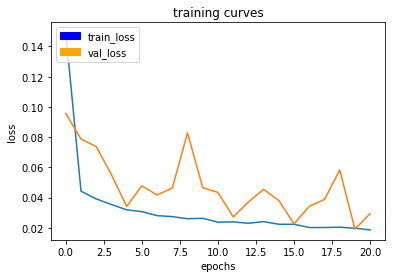

128/128 [==============================] - 73s - loss: 0.0186 - val_loss: 0.0294
Epoch 22/115
127/128 [============================>.] - ETA: 0s - loss: 0.0189

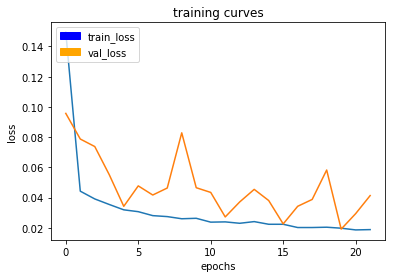

128/128 [==============================] - 73s - loss: 0.0189 - val_loss: 0.0413
Epoch 23/115
127/128 [============================>.] - ETA: 0s - loss: 0.0183

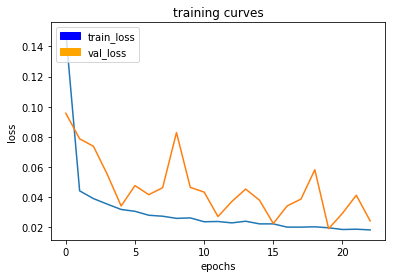

128/128 [==============================] - 73s - loss: 0.0183 - val_loss: 0.0243
Epoch 24/115
127/128 [============================>.] - ETA: 0s - loss: 0.0173

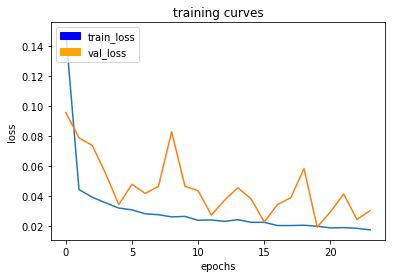

128/128 [==============================] - 73s - loss: 0.0173 - val_loss: 0.0302
Epoch 25/115
127/128 [============================>.] - ETA: 0s - loss: 0.0188

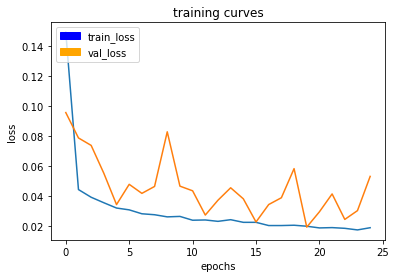

128/128 [==============================] - 73s - loss: 0.0188 - val_loss: 0.0530
Epoch 26/115
127/128 [============================>.] - ETA: 0s - loss: 0.0165

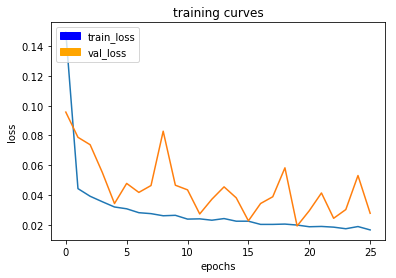

128/128 [==============================] - 73s - loss: 0.0165 - val_loss: 0.0277
Epoch 27/115
127/128 [============================>.] - ETA: 0s - loss: 0.0158

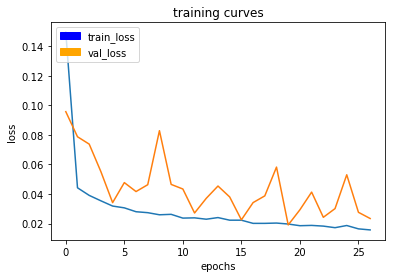

128/128 [==============================] - 73s - loss: 0.0158 - val_loss: 0.0235
Epoch 28/115
127/128 [============================>.] - ETA: 0s - loss: 0.0193

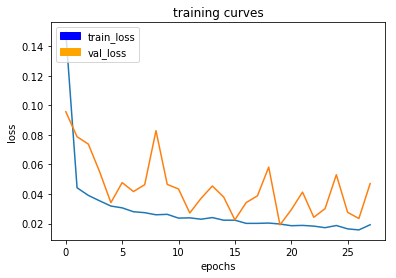

128/128 [==============================] - 73s - loss: 0.0192 - val_loss: 0.0471
Epoch 29/115
127/128 [============================>.] - ETA: 0s - loss: 0.0169

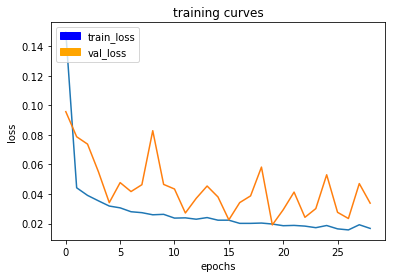

128/128 [==============================] - 74s - loss: 0.0168 - val_loss: 0.0339
Epoch 30/115
127/128 [============================>.] - ETA: 0s - loss: 0.0158

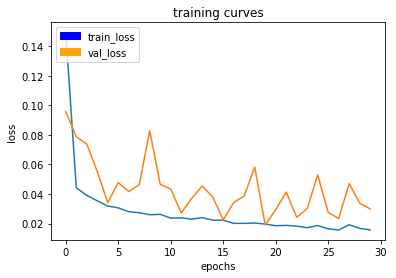

128/128 [==============================] - 74s - loss: 0.0158 - val_loss: 0.0300
Epoch 31/115
127/128 [============================>.] - ETA: 0s - loss: 0.0192

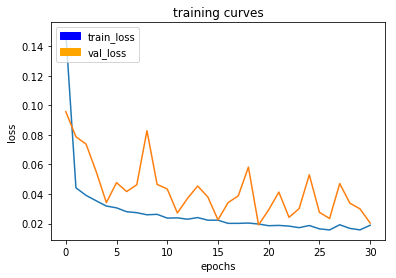

128/128 [==============================] - 73s - loss: 0.0192 - val_loss: 0.0204
Epoch 32/115
127/128 [============================>.] - ETA: 0s - loss: 0.0184

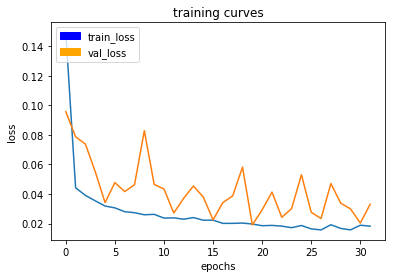

128/128 [==============================] - 73s - loss: 0.0183 - val_loss: 0.0331
Epoch 33/115
127/128 [============================>.] - ETA: 0s - loss: 0.0139

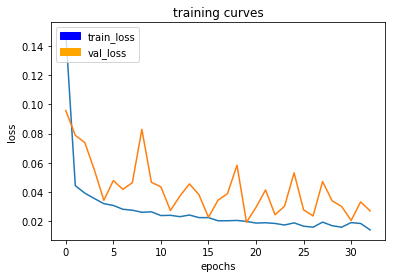

128/128 [==============================] - 73s - loss: 0.0139 - val_loss: 0.0270
Epoch 34/115
127/128 [============================>.] - ETA: 0s - loss: 0.0163

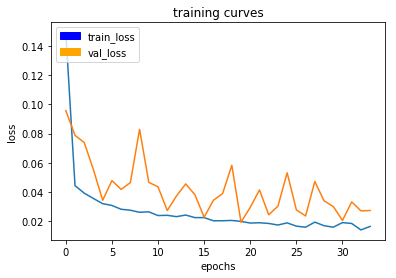

128/128 [==============================] - 73s - loss: 0.0163 - val_loss: 0.0272
Epoch 35/115
127/128 [============================>.] - ETA: 0s - loss: 0.0149

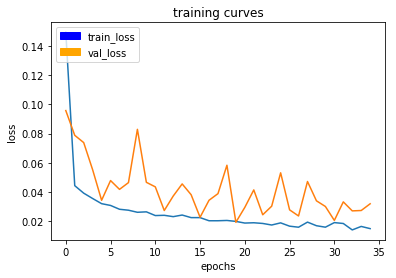

128/128 [==============================] - 73s - loss: 0.0149 - val_loss: 0.0318
Epoch 36/115
127/128 [============================>.] - ETA: 0s - loss: 0.0172

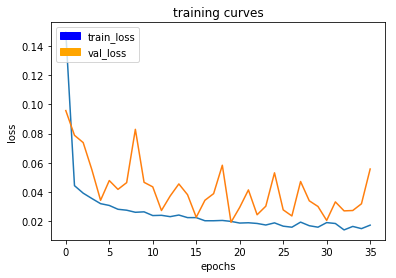

128/128 [==============================] - 73s - loss: 0.0172 - val_loss: 0.0556
Epoch 37/115
127/128 [============================>.] - ETA: 0s - loss: 0.0168

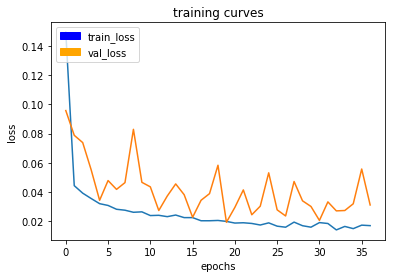

128/128 [==============================] - 73s - loss: 0.0168 - val_loss: 0.0310
Epoch 38/115
127/128 [============================>.] - ETA: 0s - loss: 0.0151

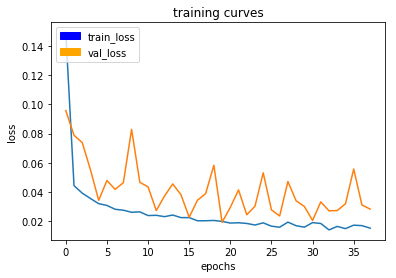

128/128 [==============================] - 73s - loss: 0.0151 - val_loss: 0.0282
Epoch 39/115
127/128 [============================>.] - ETA: 0s - loss: 0.0151

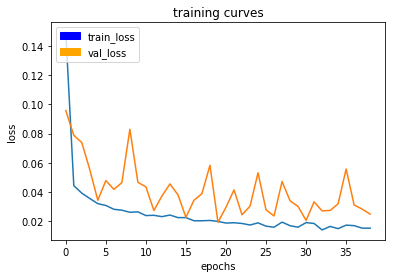

128/128 [==============================] - 73s - loss: 0.0151 - val_loss: 0.0247
Epoch 40/115
127/128 [============================>.] - ETA: 0s - loss: 0.0141

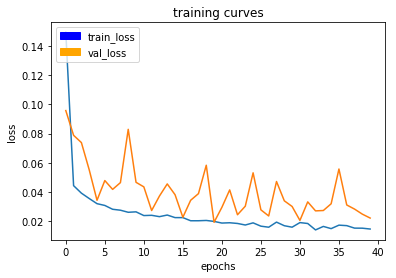

128/128 [==============================] - 73s - loss: 0.0145 - val_loss: 0.0220
Epoch 41/115
127/128 [============================>.] - ETA: 0s - loss: 0.0147

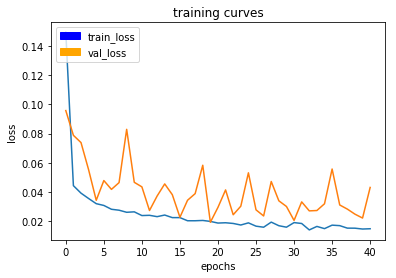

128/128 [==============================] - 73s - loss: 0.0147 - val_loss: 0.0430
Epoch 42/115
127/128 [============================>.] - ETA: 0s - loss: 0.0153

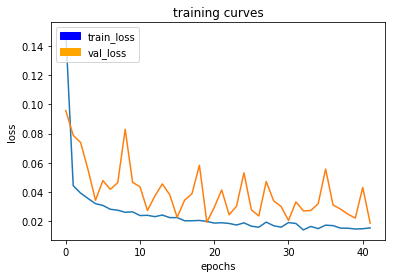

128/128 [==============================] - 73s - loss: 0.0153 - val_loss: 0.0186
Epoch 43/115
127/128 [============================>.] - ETA: 0s - loss: 0.0143

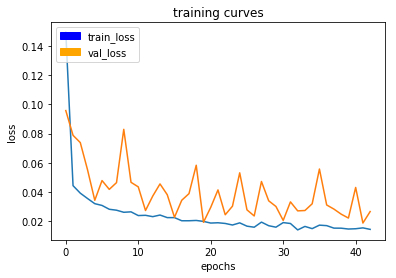

128/128 [==============================] - 73s - loss: 0.0142 - val_loss: 0.0265
Epoch 44/115
127/128 [============================>.] - ETA: 0s - loss: 0.0123

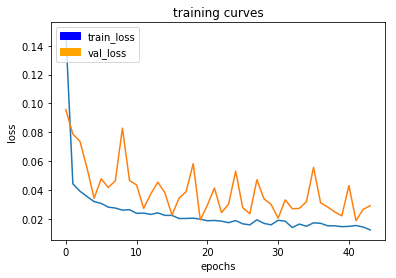

128/128 [==============================] - 73s - loss: 0.0123 - val_loss: 0.0290
Epoch 45/115
127/128 [============================>.] - ETA: 0s - loss: 0.0141

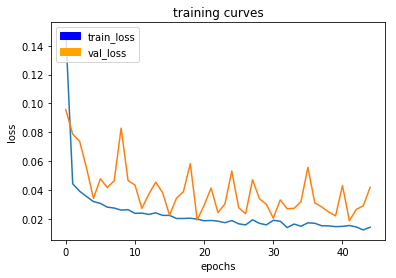

128/128 [==============================] - 73s - loss: 0.0141 - val_loss: 0.0418
Epoch 46/115
127/128 [============================>.] - ETA: 0s - loss: 0.0144

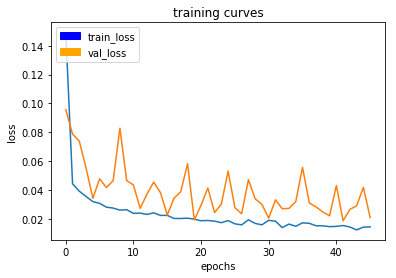

128/128 [==============================] - 73s - loss: 0.0143 - val_loss: 0.0209
Epoch 47/115
127/128 [============================>.] - ETA: 0s - loss: 0.0140

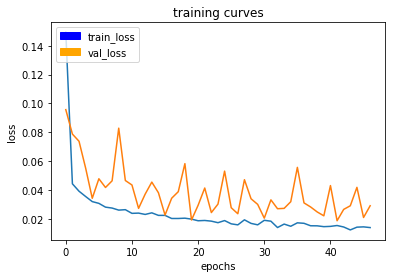

128/128 [==============================] - 73s - loss: 0.0140 - val_loss: 0.0290
Epoch 48/115
127/128 [============================>.] - ETA: 0s - loss: 0.0135

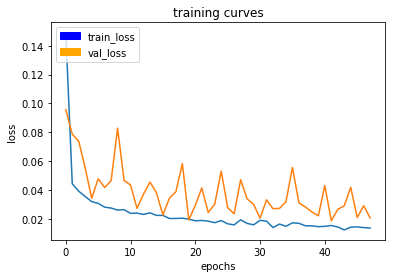

128/128 [==============================] - 73s - loss: 0.0135 - val_loss: 0.0206
Epoch 49/115
127/128 [============================>.] - ETA: 0s - loss: 0.0137

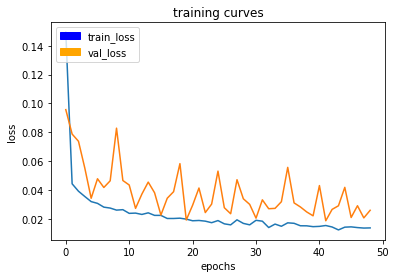

128/128 [==============================] - 73s - loss: 0.0137 - val_loss: 0.0259
Epoch 50/115
127/128 [============================>.] - ETA: 0s - loss: 0.0151

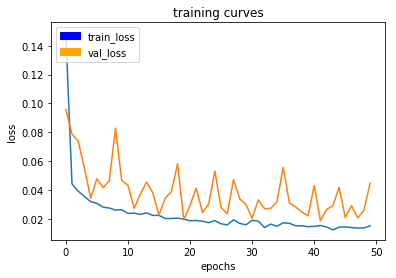

128/128 [==============================] - 73s - loss: 0.0151 - val_loss: 0.0447
Epoch 51/115
127/128 [============================>.] - ETA: 0s - loss: 0.0155

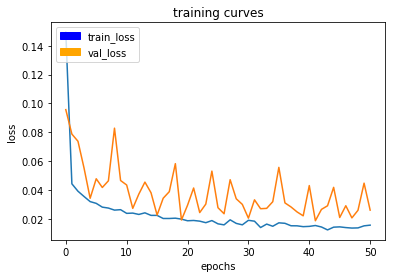

128/128 [==============================] - 73s - loss: 0.0155 - val_loss: 0.0260
Epoch 52/115
127/128 [============================>.] - ETA: 0s - loss: 0.0131

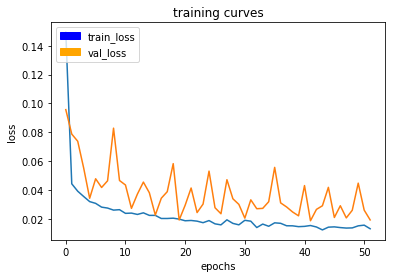

128/128 [==============================] - 73s - loss: 0.0131 - val_loss: 0.0192
Epoch 53/115
127/128 [============================>.] - ETA: 0s - loss: 0.0135

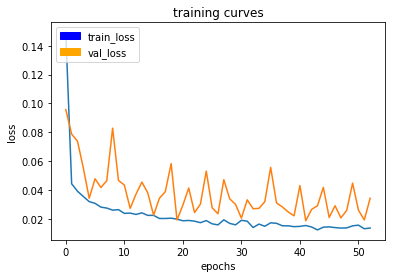

128/128 [==============================] - 73s - loss: 0.0136 - val_loss: 0.0342
Epoch 54/115
127/128 [============================>.] - ETA: 0s - loss: 0.0128

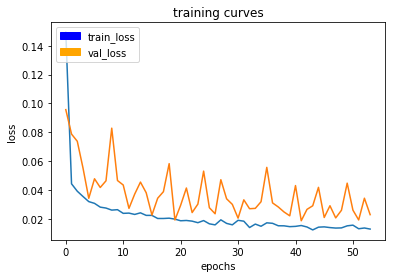

128/128 [==============================] - 73s - loss: 0.0128 - val_loss: 0.0228
Epoch 55/115
127/128 [============================>.] - ETA: 0s - loss: 0.0124

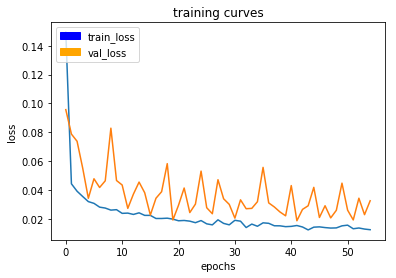

128/128 [==============================] - 73s - loss: 0.0124 - val_loss: 0.0325
Epoch 56/115
127/128 [============================>.] - ETA: 0s - loss: 0.0135

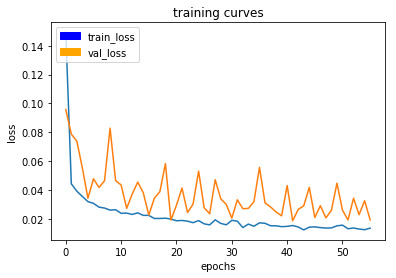

128/128 [==============================] - 73s - loss: 0.0135 - val_loss: 0.0192
Epoch 57/115
127/128 [============================>.] - ETA: 0s - loss: 0.0131

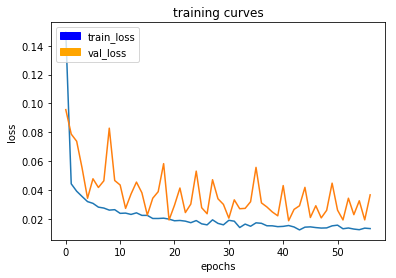

128/128 [==============================] - 73s - loss: 0.0131 - val_loss: 0.0366
Epoch 58/115
127/128 [============================>.] - ETA: 0s - loss: 0.0117

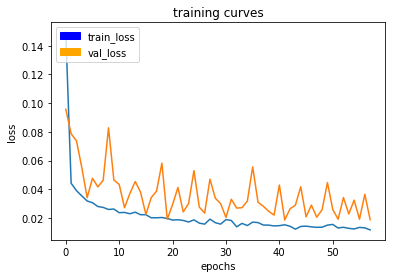

128/128 [==============================] - 73s - loss: 0.0118 - val_loss: 0.0188
Epoch 59/115
127/128 [============================>.] - ETA: 0s - loss: 0.0114

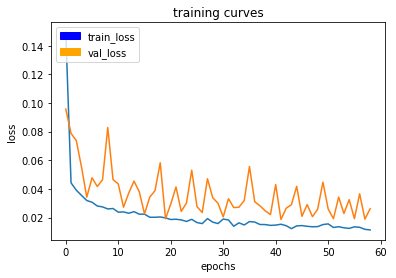

128/128 [==============================] - 73s - loss: 0.0114 - val_loss: 0.0261
Epoch 60/115
127/128 [============================>.] - ETA: 0s - loss: 0.0126

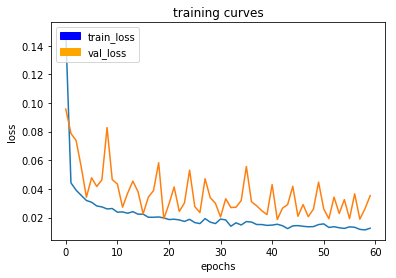

128/128 [==============================] - 73s - loss: 0.0125 - val_loss: 0.0353
Epoch 61/115
127/128 [============================>.] - ETA: 0s - loss: 0.0129

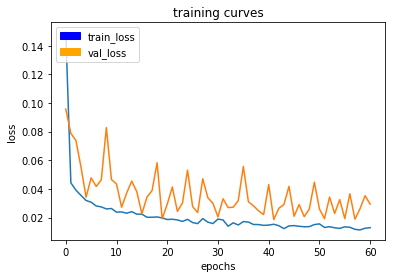

128/128 [==============================] - 73s - loss: 0.0129 - val_loss: 0.0293
Epoch 62/115
127/128 [============================>.] - ETA: 0s - loss: 0.0123

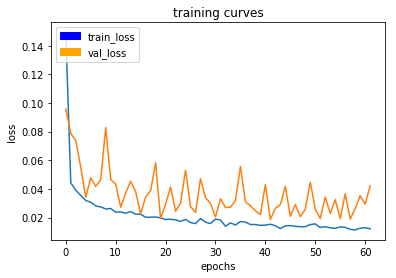

128/128 [==============================] - 73s - loss: 0.0123 - val_loss: 0.0422
Epoch 63/115
127/128 [============================>.] - ETA: 0s - loss: 0.0143

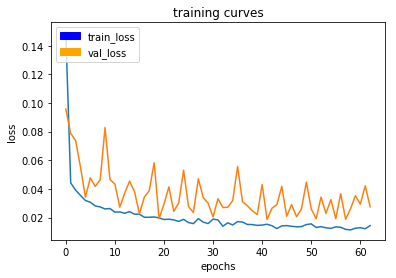

128/128 [==============================] - 73s - loss: 0.0143 - val_loss: 0.0275
Epoch 64/115
127/128 [============================>.] - ETA: 0s - loss: 0.0151

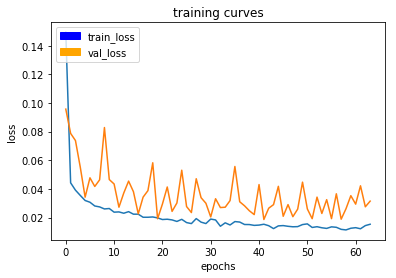

128/128 [==============================] - 73s - loss: 0.0153 - val_loss: 0.0315
Epoch 65/115
127/128 [============================>.] - ETA: 0s - loss: 0.0138

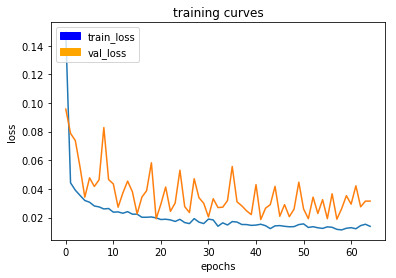

128/128 [==============================] - 73s - loss: 0.0138 - val_loss: 0.0315
Epoch 66/115
127/128 [============================>.] - ETA: 0s - loss: 0.0126

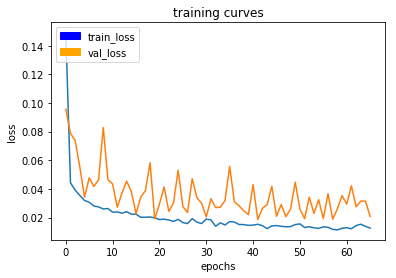

128/128 [==============================] - 74s - loss: 0.0126 - val_loss: 0.0207
Epoch 67/115
127/128 [============================>.] - ETA: 0s - loss: 0.0127

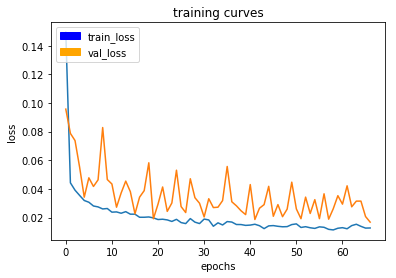

128/128 [==============================] - 73s - loss: 0.0127 - val_loss: 0.0168
Epoch 68/115
127/128 [============================>.] - ETA: 0s - loss: 0.0114

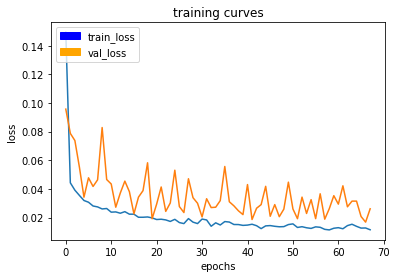

128/128 [==============================] - 73s - loss: 0.0114 - val_loss: 0.0261
Epoch 69/115
127/128 [============================>.] - ETA: 0s - loss: 0.0136

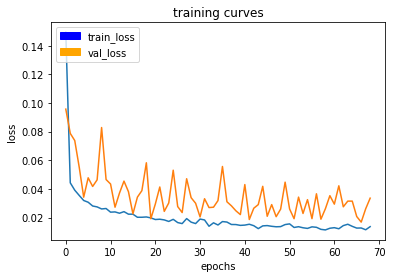

128/128 [==============================] - 73s - loss: 0.0136 - val_loss: 0.0335
Epoch 70/115
127/128 [============================>.] - ETA: 0s - loss: 0.0144

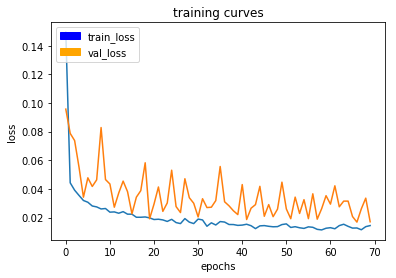

128/128 [==============================] - 73s - loss: 0.0144 - val_loss: 0.0170
Epoch 71/115
127/128 [============================>.] - ETA: 0s - loss: 0.0112

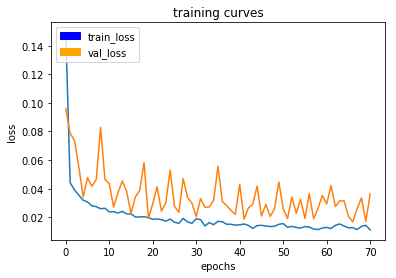

128/128 [==============================] - 73s - loss: 0.0112 - val_loss: 0.0362
Epoch 72/115
127/128 [============================>.] - ETA: 0s - loss: 0.0131

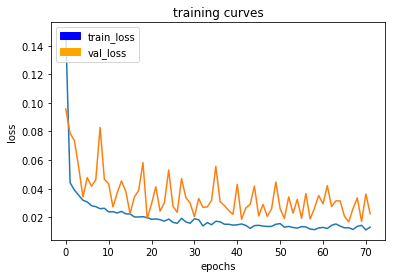

128/128 [==============================] - 73s - loss: 0.0131 - val_loss: 0.0224
Epoch 73/115
127/128 [============================>.] - ETA: 0s - loss: 0.0109

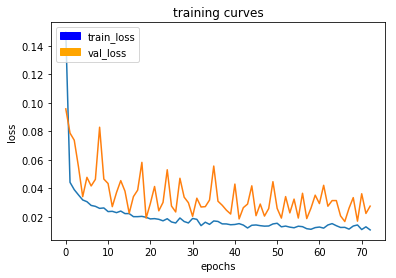

128/128 [==============================] - 73s - loss: 0.0109 - val_loss: 0.0276
Epoch 74/115
127/128 [============================>.] - ETA: 0s - loss: 0.0110

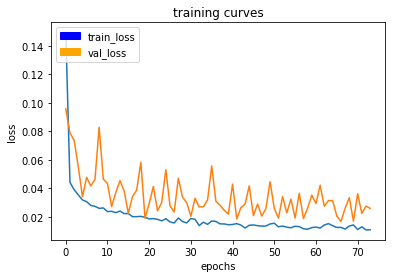

128/128 [==============================] - 73s - loss: 0.0110 - val_loss: 0.0260
Epoch 75/115
127/128 [============================>.] - ETA: 0s - loss: 0.0142

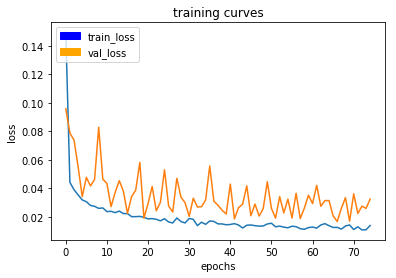

128/128 [==============================] - 73s - loss: 0.0142 - val_loss: 0.0325
Epoch 76/115
127/128 [============================>.] - ETA: 0s - loss: 0.0129

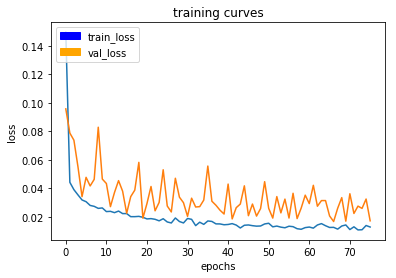

128/128 [==============================] - 73s - loss: 0.0129 - val_loss: 0.0173
Epoch 77/115
127/128 [============================>.] - ETA: 0s - loss: 0.0111

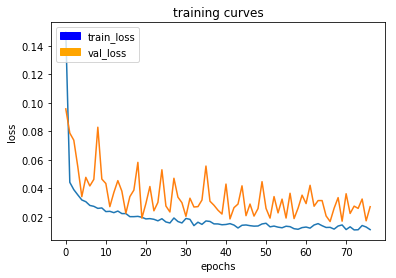

128/128 [==============================] - 73s - loss: 0.0111 - val_loss: 0.0271
Epoch 78/115
127/128 [============================>.] - ETA: 0s - loss: 0.0109

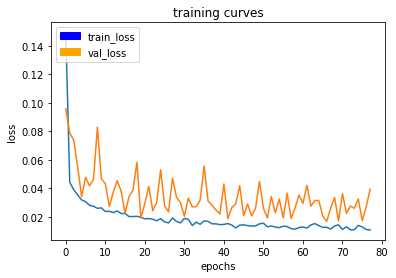

128/128 [==============================] - 73s - loss: 0.0109 - val_loss: 0.0394
Epoch 79/115
127/128 [============================>.] - ETA: 0s - loss: 0.0104

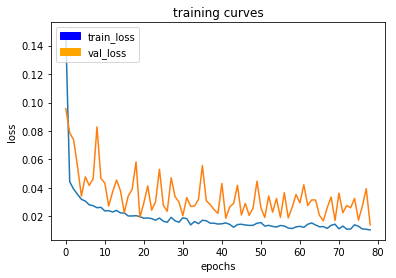

128/128 [==============================] - 73s - loss: 0.0104 - val_loss: 0.0139
Epoch 80/115
127/128 [============================>.] - ETA: 0s - loss: 0.0099

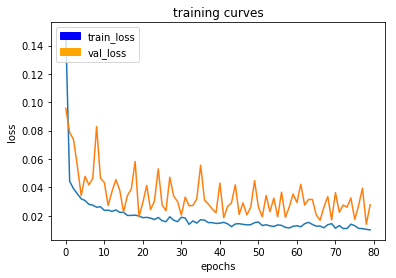

128/128 [==============================] - 73s - loss: 0.0099 - val_loss: 0.0277
Epoch 81/115
127/128 [============================>.] - ETA: 0s - loss: 0.0103

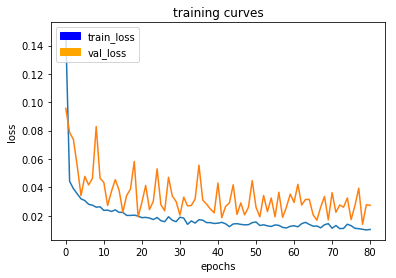

128/128 [==============================] - 74s - loss: 0.0103 - val_loss: 0.0273
Epoch 82/115
127/128 [============================>.] - ETA: 0s - loss: 0.0103

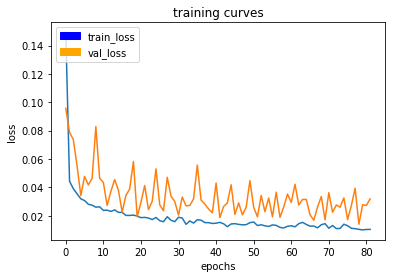

128/128 [==============================] - 73s - loss: 0.0103 - val_loss: 0.0319
Epoch 83/115
127/128 [============================>.] - ETA: 0s - loss: 0.0116

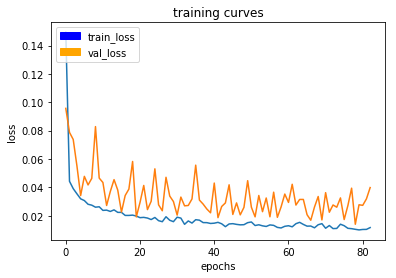

128/128 [==============================] - 73s - loss: 0.0116 - val_loss: 0.0398
Epoch 84/115
127/128 [============================>.] - ETA: 0s - loss: 0.0112

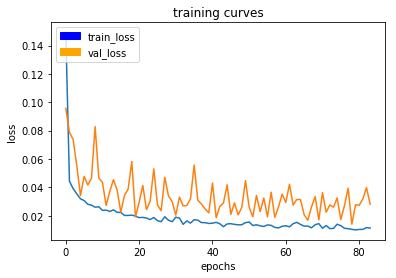

128/128 [==============================] - 73s - loss: 0.0112 - val_loss: 0.0281
Epoch 85/115
127/128 [============================>.] - ETA: 0s - loss: 0.0109

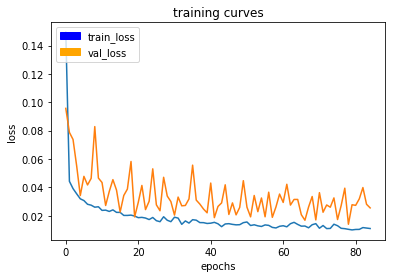

128/128 [==============================] - 73s - loss: 0.0109 - val_loss: 0.0255
Epoch 86/115
127/128 [============================>.] - ETA: 0s - loss: 0.0124

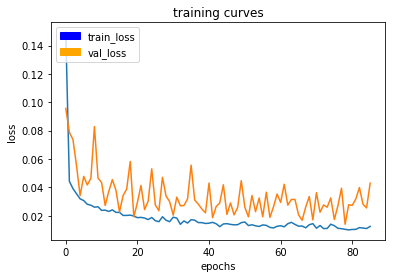

128/128 [==============================] - 73s - loss: 0.0124 - val_loss: 0.0429
Epoch 87/115
127/128 [============================>.] - ETA: 0s - loss: 0.0124

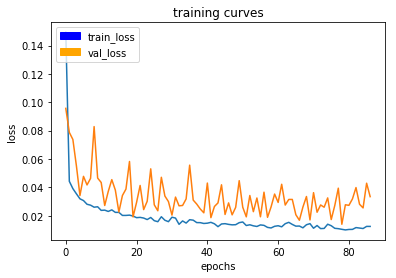

128/128 [==============================] - 73s - loss: 0.0124 - val_loss: 0.0334
Epoch 88/115
127/128 [============================>.] - ETA: 0s - loss: 0.0107

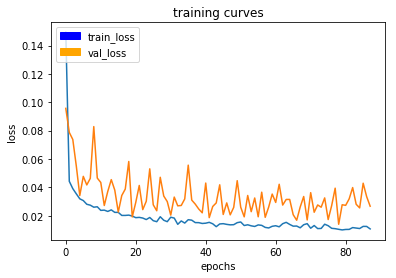

128/128 [==============================] - 73s - loss: 0.0107 - val_loss: 0.0267
Epoch 89/115
127/128 [============================>.] - ETA: 0s - loss: 0.0103

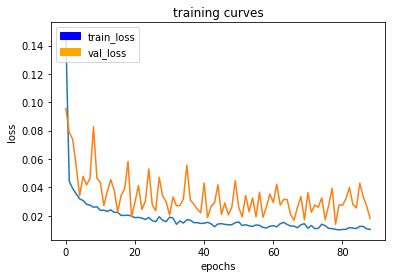

128/128 [==============================] - 73s - loss: 0.0103 - val_loss: 0.0181
Epoch 90/115
127/128 [============================>.] - ETA: 0s - loss: 0.0099

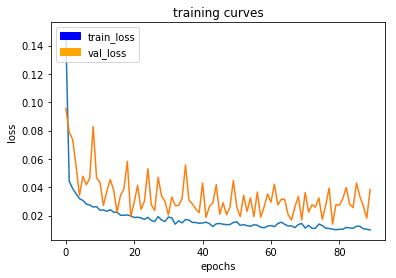

128/128 [==============================] - 73s - loss: 0.0099 - val_loss: 0.0384
Epoch 91/115
127/128 [============================>.] - ETA: 0s - loss: 0.0099

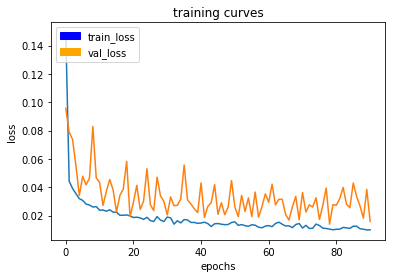

128/128 [==============================] - 73s - loss: 0.0099 - val_loss: 0.0158
Epoch 92/115
127/128 [============================>.] - ETA: 0s - loss: 0.0134

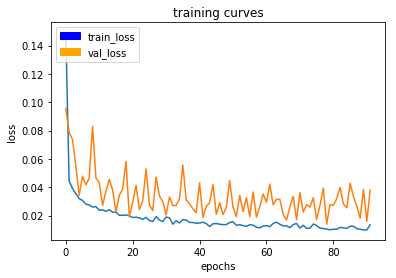

128/128 [==============================] - 73s - loss: 0.0134 - val_loss: 0.0379
Epoch 93/115
127/128 [============================>.] - ETA: 0s - loss: 0.0135

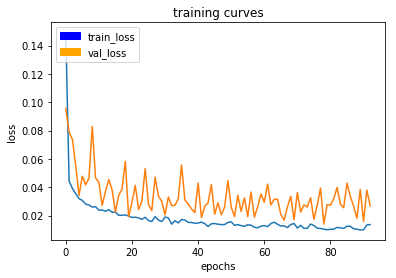

128/128 [==============================] - 73s - loss: 0.0136 - val_loss: 0.0269
Epoch 94/115
127/128 [============================>.] - ETA: 0s - loss: 0.0103

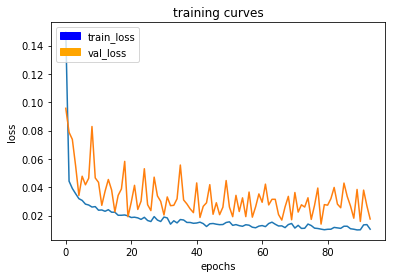

128/128 [==============================] - 73s - loss: 0.0103 - val_loss: 0.0175
Epoch 95/115
127/128 [============================>.] - ETA: 0s - loss: 0.0131

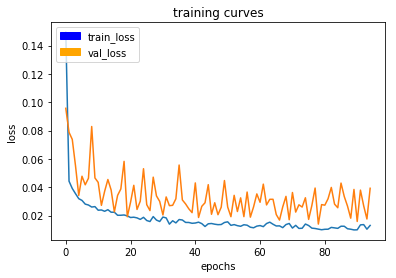

128/128 [==============================] - 73s - loss: 0.0131 - val_loss: 0.0392
Epoch 96/115
127/128 [============================>.] - ETA: 0s - loss: 0.0110

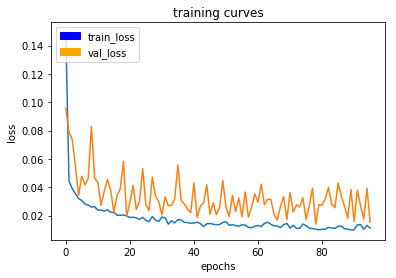

128/128 [==============================] - 73s - loss: 0.0110 - val_loss: 0.0152
Epoch 97/115
127/128 [============================>.] - ETA: 0s - loss: 0.0120

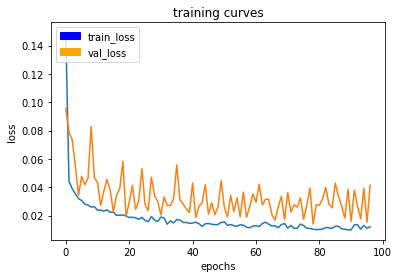

128/128 [==============================] - 73s - loss: 0.0120 - val_loss: 0.0415
Epoch 98/115
127/128 [============================>.] - ETA: 0s - loss: 0.0112

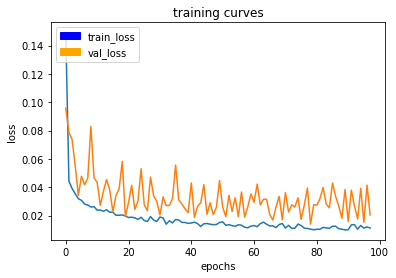

128/128 [==============================] - 73s - loss: 0.0112 - val_loss: 0.0204
Epoch 99/115
127/128 [============================>.] - ETA: 0s - loss: 0.0103

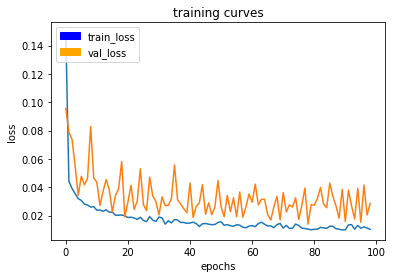

128/128 [==============================] - 73s - loss: 0.0103 - val_loss: 0.0285
Epoch 100/115
127/128 [============================>.] - ETA: 0s - loss: 0.0099

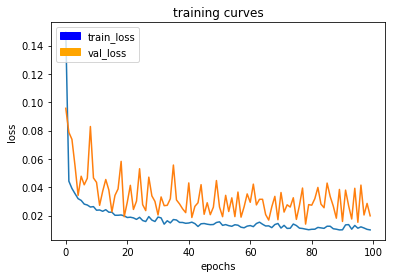

128/128 [==============================] - 73s - loss: 0.0099 - val_loss: 0.0198
Epoch 101/115
127/128 [============================>.] - ETA: 0s - loss: 0.0096

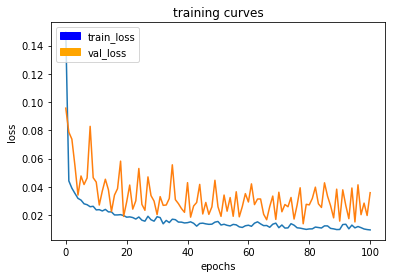

128/128 [==============================] - 74s - loss: 0.0096 - val_loss: 0.0359
Epoch 102/115
127/128 [============================>.] - ETA: 0s - loss: 0.0096

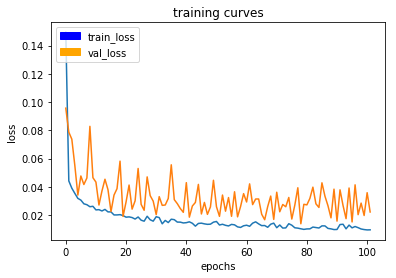

128/128 [==============================] - 73s - loss: 0.0096 - val_loss: 0.0223
Epoch 103/115
127/128 [============================>.] - ETA: 0s - loss: 0.0094

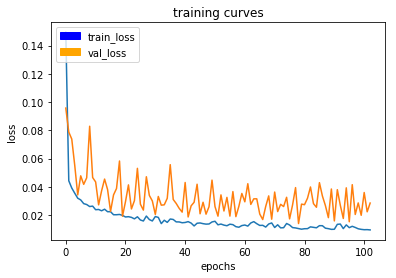

128/128 [==============================] - 73s - loss: 0.0094 - val_loss: 0.0285
Epoch 104/115
127/128 [============================>.] - ETA: 0s - loss: 0.0093

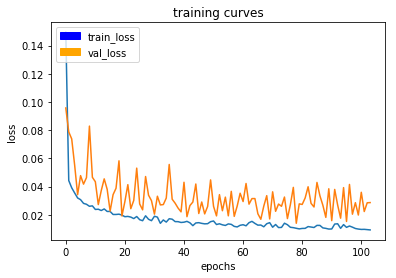

128/128 [==============================] - 73s - loss: 0.0092 - val_loss: 0.0286
Epoch 105/115
127/128 [============================>.] - ETA: 0s - loss: 0.0112

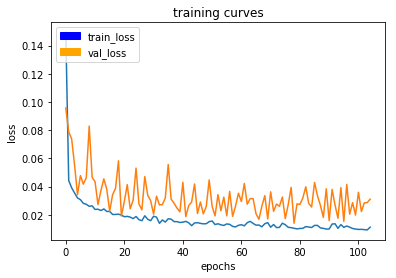

128/128 [==============================] - 73s - loss: 0.0112 - val_loss: 0.0310
Epoch 106/115
127/128 [============================>.] - ETA: 0s - loss: 0.0106

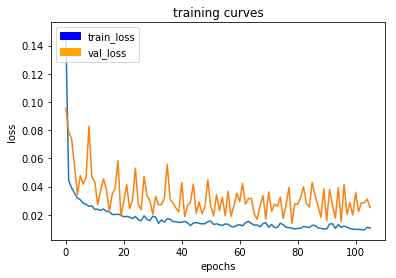

128/128 [==============================] - 74s - loss: 0.0106 - val_loss: 0.0251
Epoch 107/115
127/128 [============================>.] - ETA: 0s - loss: 0.0097

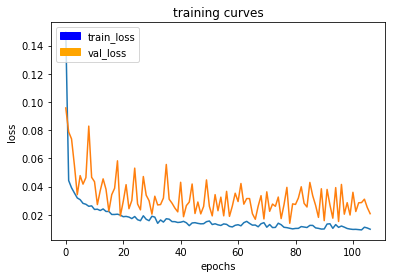

128/128 [==============================] - 73s - loss: 0.0097 - val_loss: 0.0207
Epoch 108/115
127/128 [============================>.] - ETA: 0s - loss: 0.0097

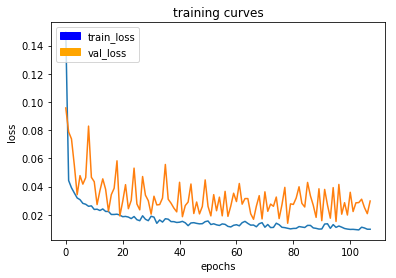

128/128 [==============================] - 73s - loss: 0.0097 - val_loss: 0.0297
Epoch 109/115
127/128 [============================>.] - ETA: 0s - loss: 0.0118

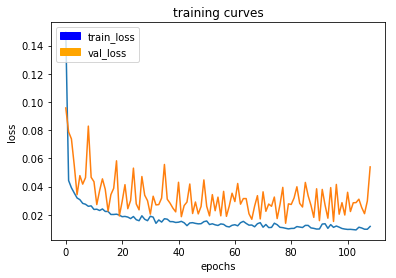

128/128 [==============================] - 73s - loss: 0.0118 - val_loss: 0.0539
Epoch 110/115
127/128 [============================>.] - ETA: 0s - loss: 0.0131

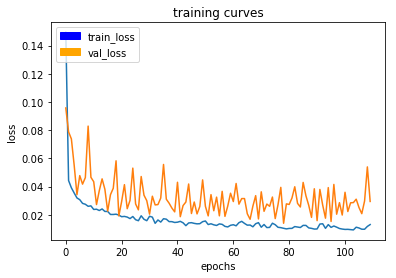

128/128 [==============================] - 73s - loss: 0.0131 - val_loss: 0.0294
Epoch 111/115
127/128 [============================>.] - ETA: 0s - loss: 0.0120

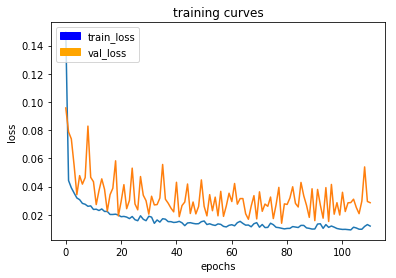

128/128 [==============================] - 73s - loss: 0.0120 - val_loss: 0.0285
Epoch 112/115
127/128 [============================>.] - ETA: 0s - loss: 0.0109

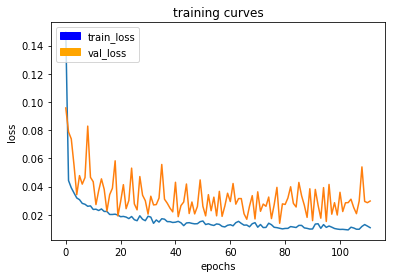

128/128 [==============================] - 73s - loss: 0.0108 - val_loss: 0.0297
Epoch 113/115
127/128 [============================>.] - ETA: 0s - loss: 0.0104

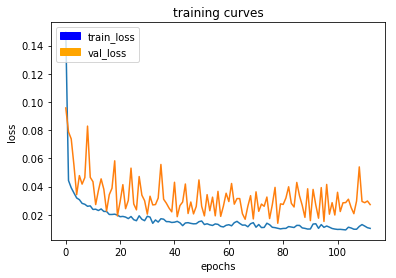

128/128 [==============================] - 74s - loss: 0.0104 - val_loss: 0.0272
Epoch 114/115
127/128 [============================>.] - ETA: 0s - loss: 0.0104

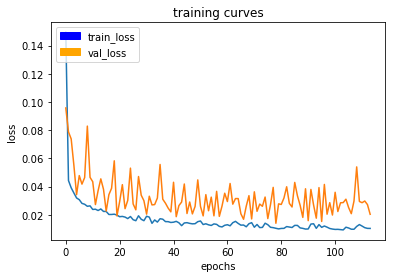

128/128 [==============================] - 73s - loss: 0.0104 - val_loss: 0.0203
Epoch 115/115
127/128 [============================>.] - ETA: 0s - loss: 0.0097

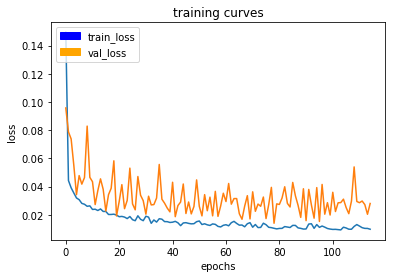

128/128 [==============================] - 73s - loss: 0.0097 - val_loss: 0.0280


In [8]:
#Run 2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

learning_rate = 0.01
batch_size = 32
num_epochs = 115
steps_per_epoch = int(4131/batch_size)-1#200
validation_steps = validation_steps = int(1000/batch_size)-1
workers = 1 # Using GPU.

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

# Save your trained model weights
weight_file_name = 'model_weights-2'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [ ]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [9]:
run_num = 'run_2'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

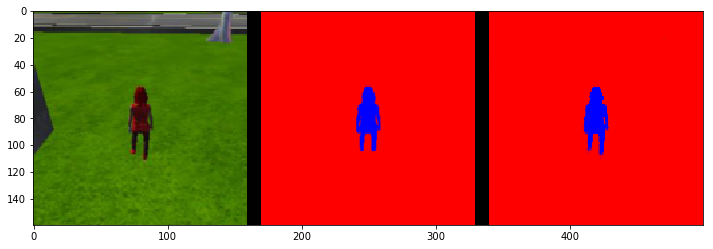

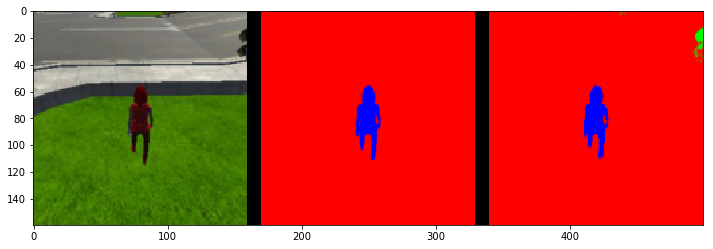

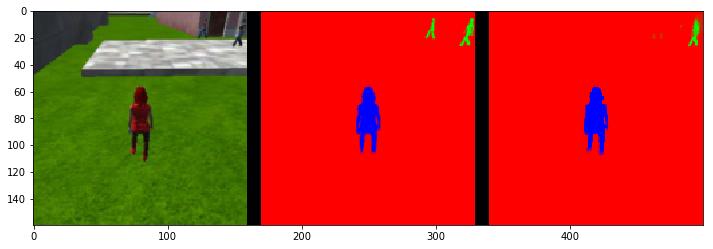

In [10]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

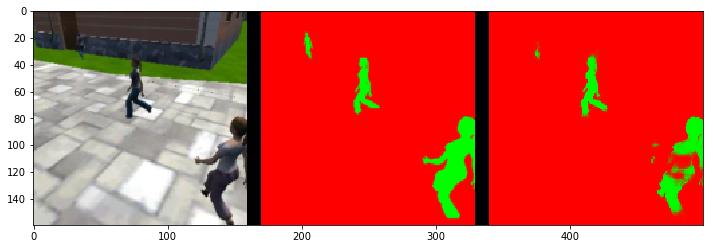

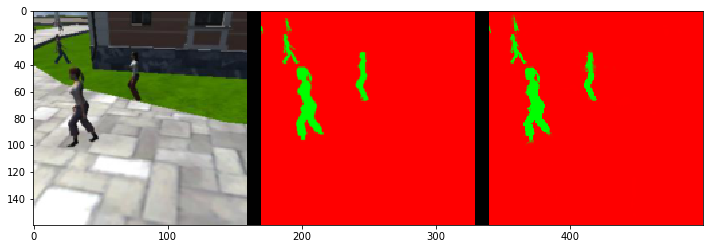

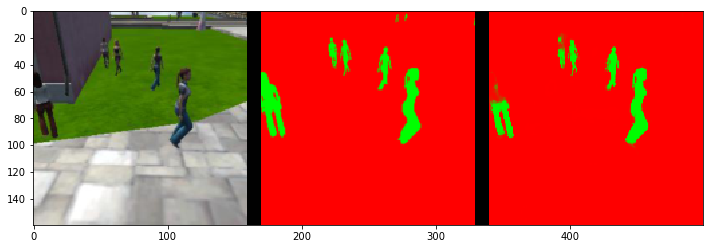

In [11]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

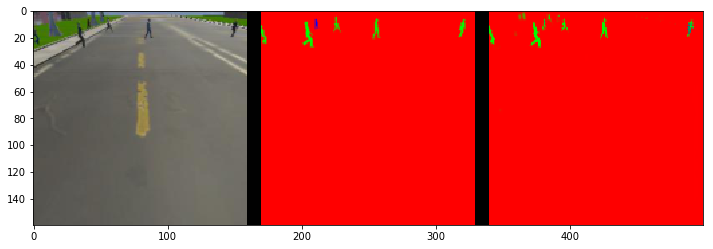

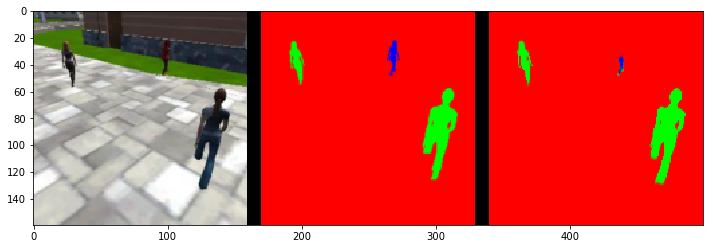

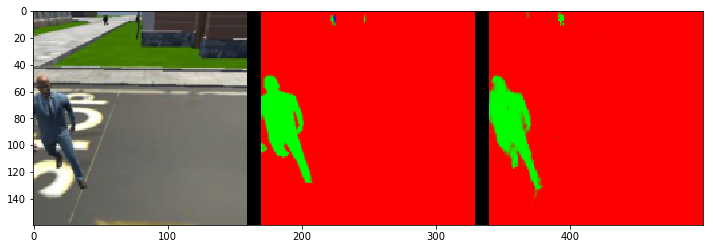

In [12]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [13]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9965918930294348
average intersection over union for other people is 0.4156018979835764
average intersection over union for the hero is 0.918219058838719
number true positives: 539, number false positives: 0, number false negatives: 0


In [14]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9896461582931216
average intersection over union for other people is 0.7972887652579831
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 30, number false negatives: 0


In [15]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9970258887276762
average intersection over union for other people is 0.48810254263717745
average intersection over union for the hero is 0.21821227960944378
number true positives: 118, number false positives: 0, number false negatives: 183


In [16]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7551724137931034


In [17]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.568215669224


In [18]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.429100798483
